<a href="https://colab.research.google.com/github/ImitatedSky/stock-exchange.rate/blob/main/stock_LSTM_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt


plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime



In [90]:
# 台積電
df = pdr.get_data_yahoo('2330.TW', start='2012-01-01', end=datetime.now())
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,75.000000,75.400002,69.800003,69.800003,48.948769,26261000
2012-01-03,75.500000,75.900002,70.500000,70.500000,49.439667,56936000
2012-01-04,76.099998,76.099998,70.500000,70.500000,49.439667,56684000
2012-01-05,76.000000,76.000000,75.300003,76.000000,53.296658,56718000
2012-01-06,75.900002,75.900002,74.900002,75.599998,53.016148,29866000
...,...,...,...,...,...,...
2023-10-30,531.000000,534.000000,528.000000,532.000000,532.000000,21404842
2023-10-31,535.000000,535.000000,527.000000,529.000000,529.000000,25667058
2023-11-01,533.000000,533.000000,527.000000,528.000000,528.000000,13603347


In [104]:
'''
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price TW ($)', fontsize=18)
plt.show()
'''

"\nplt.figure(figsize=(16,6))\nplt.title('Close Price History')\nplt.plot(df['Close'])\nplt.xlabel('Date', fontsize=18)\nplt.ylabel('Close Price TW ($)', fontsize=18)\nplt.show()\n"

In [92]:
# Create a new dataframe with only the 'Close column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
# 將所有的95%放下去測試
training_data_len = int(np.ceil( len(dataset) * .95 ))

print(f"總共資料筆數{len(dataset)} , 訓練資料筆數{training_data_len}")

總共資料筆數2892 , 訓練資料筆數2748


In [93]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.        ],
       [0.00114155],
       [0.00114155],
       ...,
       [0.74722766],
       [0.77821265],
       [0.78147423]])

建立訓練資料

In [94]:
# Create the training data set
# Create the scaled training data set
# 全部都拿下去訓練
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
timesteps = 30
x_train = []
y_train = []

for i in range(timesteps, len(train_data)):
    x_train.append(train_data[i-timesteps:i, 0])
    y_train.append(train_data[i, 0])
    if i<= timesteps + 1:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data (樣本數, 時間步數, 特徵數)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.        , 0.00114155, 0.00114155, 0.01011089, 0.00945857,
       0.00945857, 0.01092628, 0.01092628, 0.01174168, 0.01255707,
       0.00896934, 0.00945857, 0.01125244, 0.01451401, 0.01418786,
       0.01174168, 0.01141553, 0.01043704, 0.012394  , 0.012394  ,
       0.01255707, 0.01337247, 0.0115786 , 0.01108936, 0.01223092,
       0.01418786, 0.01418786, 0.01663405, 0.01663405, 0.01663405])]
[0.01614480421682063]

[array([0.        , 0.00114155, 0.00114155, 0.01011089, 0.00945857,
       0.00945857, 0.01092628, 0.01092628, 0.01174168, 0.01255707,
       0.00896934, 0.00945857, 0.01125244, 0.01451401, 0.01418786,
       0.01174168, 0.01141553, 0.01043704, 0.012394  , 0.012394  ,
       0.01255707, 0.01337247, 0.0115786 , 0.01108936, 0.01223092,
       0.01418786, 0.01418786, 0.01663405, 0.01663405, 0.01663405]), array([0.00114155, 0.00114155, 0.01011089, 0.00945857, 0.00945857,
       0.01092628, 0.01092628, 0.01174168, 0.01255707, 0.00896934,
       0.00945857, 0.01125244, 0.

**建立訓練模型**

In [95]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
#
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error' , metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2718/2718 [==============================] - 78s 27ms/step - loss: 0.0013 - accuracy: 3.6792e-04


測試資料


剩下5%的資料




In [100]:
# Create the testing data set
# Create a new array containing scaled values from index 2748 to 2892  ，共 144
test_data = scaled_data[training_data_len - timesteps: , :]
# Create the data sets x_test and y_test
x_test = []
y_test_scaled_data = scaled_data[training_data_len:, :]
y_test = dataset[training_data_len:, :]  # 這邊是沒有經過scaler 的資料

for i in range(timesteps, len(test_data)):
    x_test.append(test_data[i-timesteps:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)


# Reshape the data (樣本數, 時間步數, 特徵數)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)

loss, acc = model.evaluate(x_test, y_test_scaled_data)
print(f"accuracy：{acc}") # in LSTM models ， 'accuracy' metric is not typically used.
print(f"loss：{loss}")


# inverse scaler
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"rmse : {rmse}")

5/5 [==============================] - 0s 17ms/step - loss: 5.6981e-04 - accuracy: 0.0000e+00
accuracy：0.0
loss：0.0005698077729903162
rmse : 14.637472429795064


<ipython-input-101-6b4a3b4f3d45>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


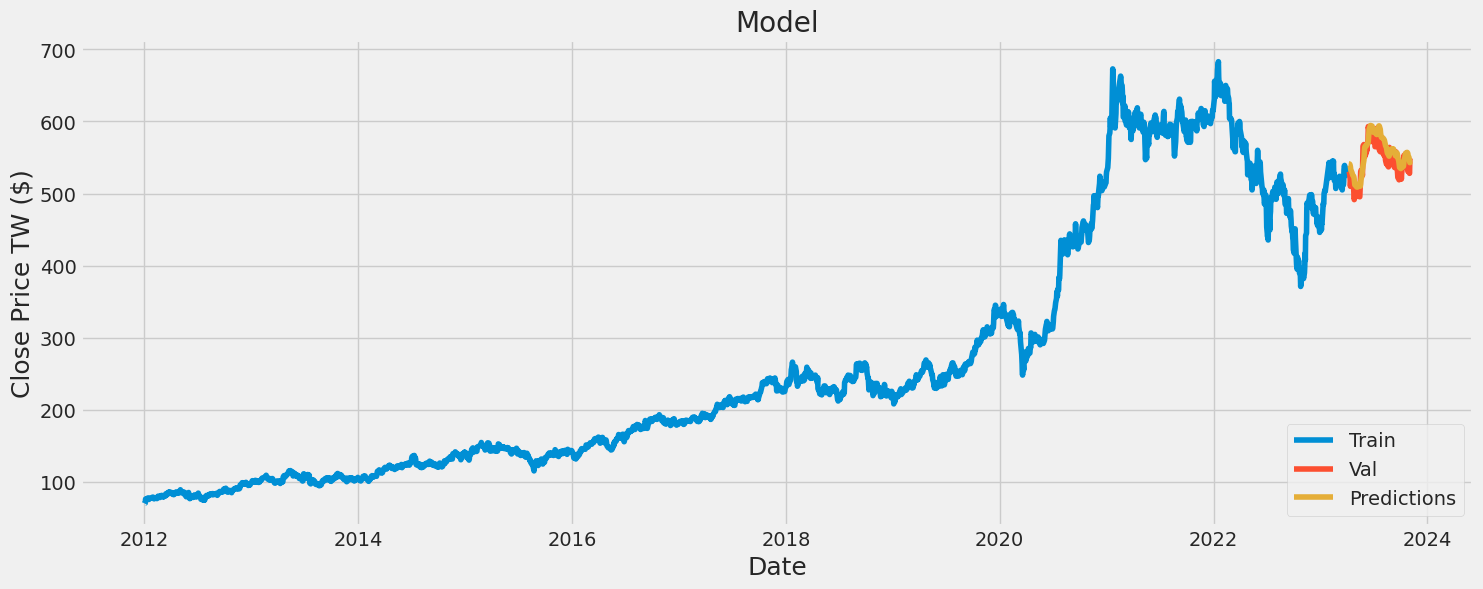

In [101]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price TW ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<ipython-input-102-ad9b07077037>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


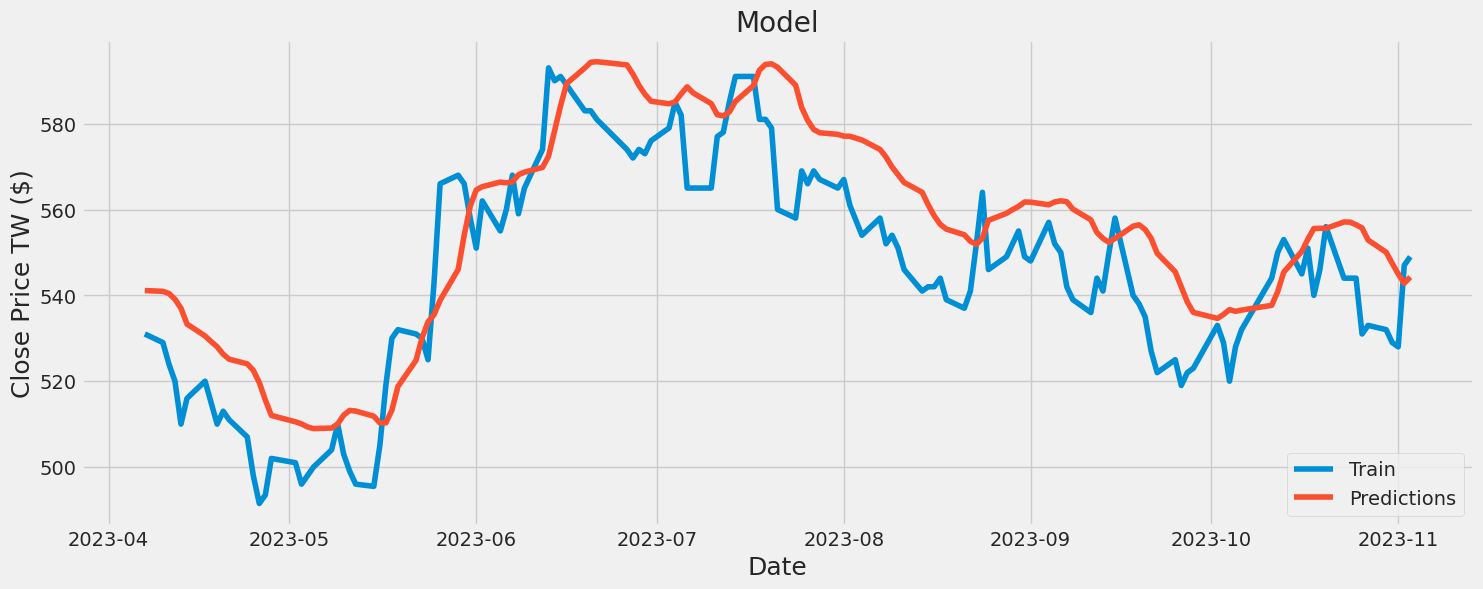

In [102]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price TW ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train',  'Predictions'], loc='lower right')
plt.show()

In [103]:
valid

,Close,Predictions
Date,,
2023-04-07,531.0,541.119629
2023-04-10,529.0,540.933228
2023-04-11,524.0,540.431702
2023-04-12,520.0,539.093445
2023-04-13,510.0,536.993958
...,...,...
2023-10-30,532.0,550.038635
2023-10-31,529.0,547.467224
2023-11-01,528.0,544.983948
